# Analysis – Encrypted Data

In [1]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
import seaborn as sns

from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.preprocessing import MinMaxScaler
from scipy.special import expit as logistic_function

## Load Data

In [2]:
df = pd.read_csv('../data/preprocessed_data_encrypted.csv')
df

,video_on,num_clients,topology,vpn,vpn_topology,total_packets,total_bytes,avg_bytes,std_bytes,median_bytes,...,total_packets_out,total_bytes_out,avg_bytes_out,std_bytes_out,median_bytes_out,max_bytes_out,avg_inter_arr,std_inter_arr,median_inter_arr,max_inter_arr
0,False,3,hdumb,ipsec,sts,78058,19889600,254.805401,355.695674,144.0,...,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,False,3,hdumb,ipsec,sts,78752,20023796,254.263968,356.137637,144.0,...,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,False,3,hdumb,ipsec,sts,78322,20024832,255.673144,354.039984,148.0,...,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,False,8,hdumb,ipsec,sts,369923,76635896,207.167156,274.104510,140.0,...,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,False,8,hdumb,ipsec,sts,354597,74016220,208.733351,279.485591,140.0,...,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
170,False,3,tiered,ipsec,sts,78071,19920524,255.159073,357.691380,144.0,...,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
171,False,3,tiered,ipsec,sts,78268,19980948,255.288854,357.237332,144.0,...,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
172,True,3,tiered,ipsec,sts,218203,120200164,550.863939,436.794183,424.0,...,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
173,True,3,tiered,ipsec,sts,214870,119552382,556.394015,436.994796,436.0,...,0,0,NaN,NaN,NaN,NaN,0.002089,0.002308,0.001315,0.007799


In [3]:
df_filtered = df.iloc[:, :11].copy()
df_filtered.describe()

,num_clients,total_packets,total_bytes,avg_bytes,std_bytes,median_bytes,max_bytes
count,175.000000,175.000000,1.750000e+02,175.000000,175.000000,175.000000,175.00000
mean,5.257143,327901.582857,1.429804e+08,371.216185,359.542178,253.680000,1471.20000
std,2.039028,276998.313377,1.511246e+08,183.088502,138.708641,181.632446,13.03576
min,3.000000,9085.000000,1.005746e+06,85.480782,30.263820,77.000000,1452.00000
25%,3.000000,105566.500000,2.407756e+07,215.961508,310.615656,140.000000,1452.00000
50%,5.000000,242137.000000,7.505303e+07,460.601483,418.192284,148.000000,1480.00000
75%,8.000000,451814.500000,2.366878e+08,537.376448,436.815762,414.000000,1480.00000
max,8.000000,992056.000000,5.093500e+08,838.362663,663.136607,1452.000000,1480.00000


In [4]:
df_filtered.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 175 entries, 0 to 174
Data columns (total 11 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   video_on       175 non-null    bool   
 1   num_clients    175 non-null    int64  
 2   topology       175 non-null    object 
 3   vpn            175 non-null    object 
 4   vpn_topology   175 non-null    object 
 5   total_packets  175 non-null    int64  
 6   total_bytes    175 non-null    int64  
 7   avg_bytes      175 non-null    float64
 8   std_bytes      175 non-null    float64
 9   median_bytes   175 non-null    float64
 10  max_bytes      175 non-null    int64  
dtypes: bool(1), float64(3), int64(4), object(3)
memory usage: 14.0+ KB


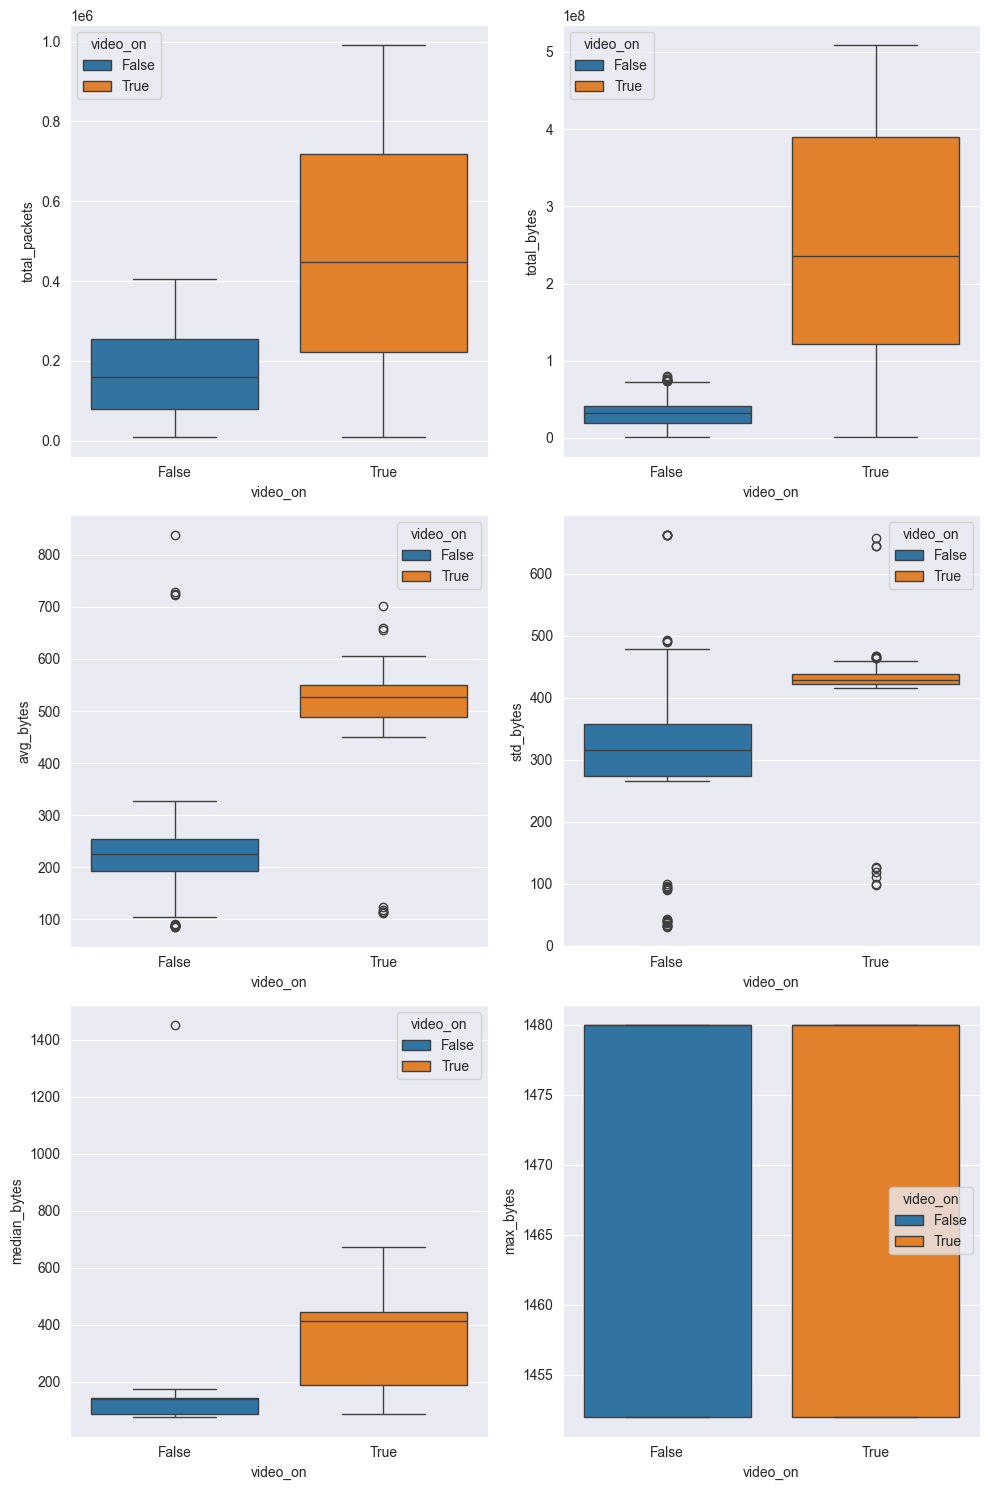

In [9]:
count = 1 # Initialize counter for subplot index

# Calculate the total number of plots to determine figure size and whether an additional subplot should be ignored
total_plots = sum(col not in ['video_on', 'num_clients', 'topology', 'vpn', 'vpn_topology'] for col in df_filtered.columns)
plt.figure(figsize=(10, 5 * (total_plots//2)))

for col in df_filtered.columns:
    if col not in ['video_on', 'num_clients', 'topology', 'vpn', 'vpn_topology']:
        # Create subplot position: 1 row, 2 columns, index by count
        plt.subplot(total_plots//2 + total_plots%2, 2, count)
        sns.boxplot(x='video_on', y=col, data=df_filtered, hue='video_on')
        count += 1 # Increment subplot index for the next plot

plt.tight_layout() # Adjust layout
plt.show()

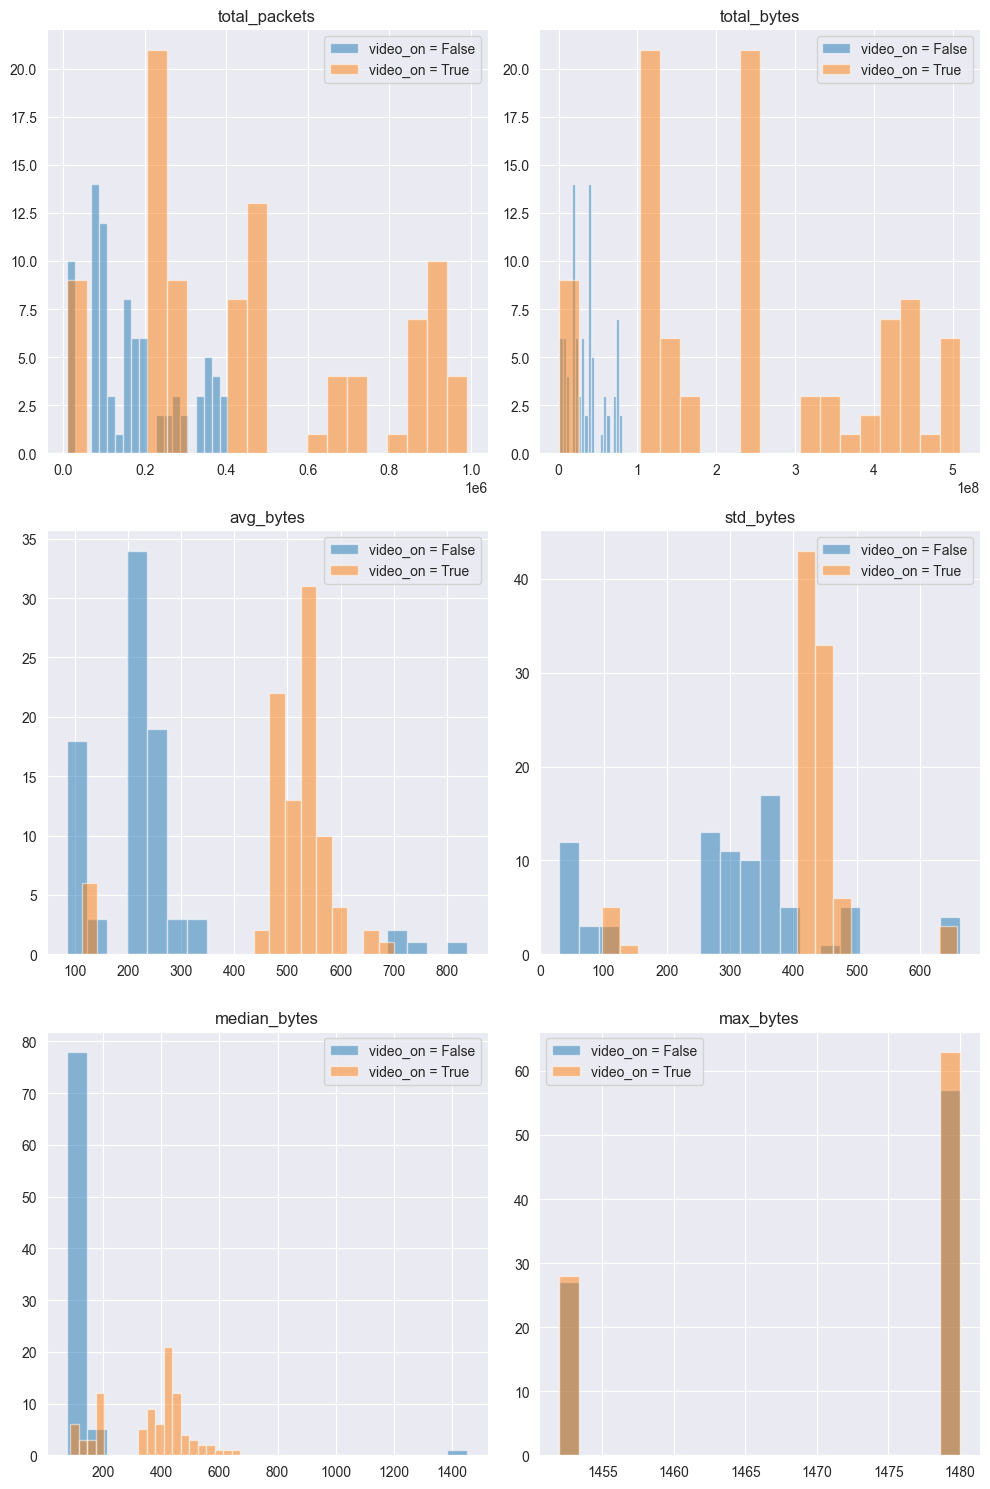

In [15]:
count = 1 # Initialize counter for subplot index

# Calculate the total number of plots to determine figure size and whether an additional subplot should be ignored
total_plots = sum(col not in ['video_on', 'num_clients', 'topology', 'vpn', 'vpn_topology'] for col in df_filtered.columns)
plt.figure(figsize=(10, 5 * (total_plots//2)))

for col in df_filtered.columns:
    if col not in ['video_on', 'num_clients', 'topology', 'vpn', 'vpn_topology']:
        # Create subplot position: 1 row, 2 columns, index by count
        plt.subplot(total_plots//2 + total_plots%2, 2, count)
        for value in df_filtered['video_on'].unique():
            subset = df_filtered[df_filtered['video_on'] == value]
            plt.hist(subset[col], bins=20, alpha=0.5, label=f'video_on = {value}')
        
        plt.title(col)
        plt.legend()
        
        count += 1
        
plt.tight_layout() # Adjust layout
plt.show()

## Multivariate Analysis

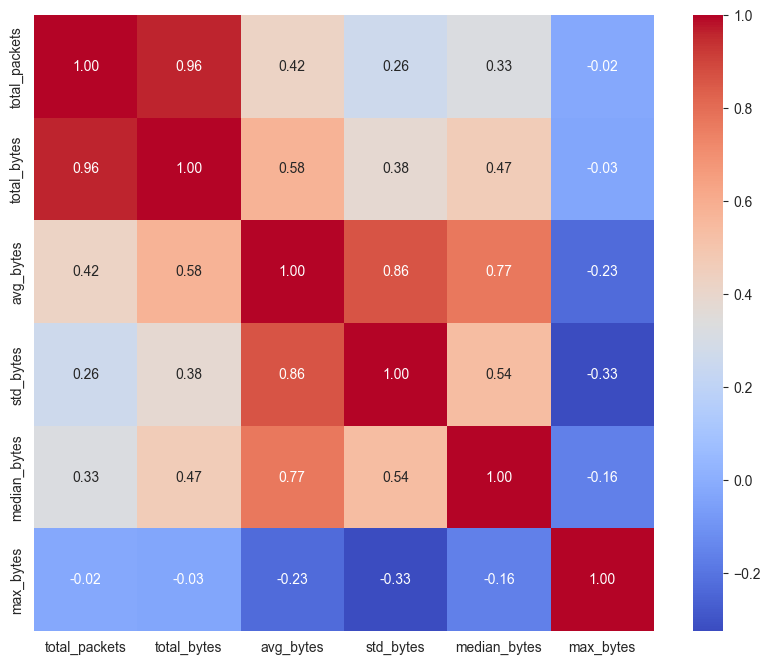

In [17]:
# Correlation Matrix
plt.figure(figsize=(10, 8))
corr = df_filtered.drop(['video_on', 'num_clients', 'topology', 'vpn', 'vpn_topology'], axis=1).corr()
sns.heatmap(corr, cmap='coolwarm', annot=True, fmt=".2f")
plt.show()

## Logistic Regression

In [18]:
X = df[['avg_bytes']]
X = sm.add_constant(X)
y = df['video_on']

logit_model = sm.Logit(y, X)
result = logit_model.fit()
result.summary()

Optimization terminated successfully.
         Current function value: 0.357859
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:               video_on   No. Observations:                  175
Model:                          Logit   Df Residuals:                      173
Method:                           MLE   Df Model:                            1
Date:                Wed, 10 Apr 2024   Pseudo R-squ.:                  0.4831
Time:                        10:45:22   Log-Likelihood:                -62.625
converged:                       True   LL-Null:                       -121.16
Covariance Type:            nonrobust   LLR p-value:                 2.770e-27
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -4.5127      0.617     -7.311      0.000      -5.722      -3.303
avg_bytes      0.0125      0.002      7.993      0.000       0.009       0.016
==============================================================================
"""

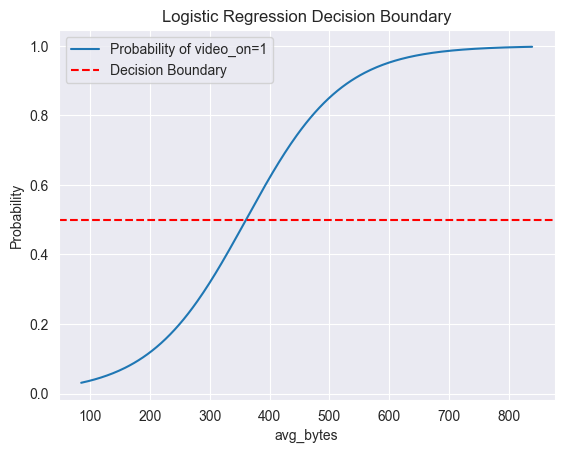

In [19]:
# Generate a range of avg_bytes values covering the observed range
avg_bytes_range = np.linspace(df['avg_bytes'].min(), df['avg_bytes'].max(), 300)

# Add a constant term to the range for prediction
X_new = sm.add_constant(avg_bytes_range)

predicted_probs = result.predict(X_new)

# Plot the predicted probabilities
plt.plot(avg_bytes_range, predicted_probs, label='Probability of video_on=1')

# Add the decision boundary at probability=0.5
plt.axhline(y=0.5, color='red', linestyle='--', label='Decision Boundary')

# Label the plot
plt.xlabel('avg_bytes')
plt.ylabel('Probability')
plt.title('Logistic Regression Decision Boundary')
plt.legend()

plt.show()

In [20]:
X = df[['std_bytes']]
X = sm.add_constant(X)
y = df['video_on']

logit_model = sm.Logit(y, X)
result = logit_model.fit()
result.summary()

Optimization terminated successfully.
         Current function value: 0.574897
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:               video_on   No. Observations:                  175
Model:                          Logit   Df Residuals:                      173
Method:                           MLE   Df Model:                            1
Date:                Wed, 10 Apr 2024   Pseudo R-squ.:                  0.1696
Time:                        10:45:43   Log-Likelihood:                -100.61
converged:                       True   LL-Null:                       -121.16
Covariance Type:            nonrobust   LLR p-value:                 1.441e-10
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -3.2851      0.725     -4.530      0.000      -4.707      -1.864
std_bytes      0.0092      0.002      4.941      0.000       0.006       0.013
==============================================================================
"""

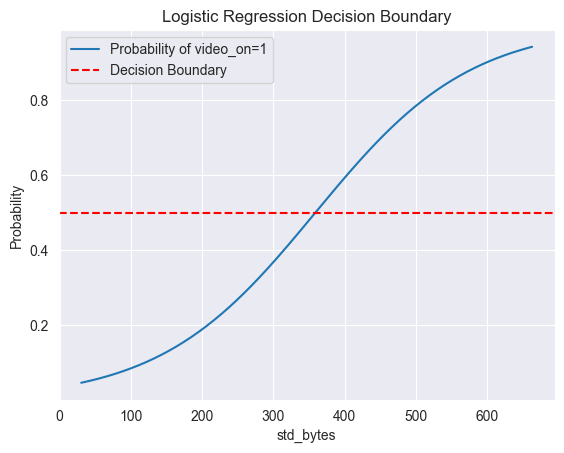

In [21]:
# Generate a range of avg_bytes values covering the observed range
std_bytes_range = np.linspace(df['std_bytes'].min(), df['std_bytes'].max(), 300)

# Add a constant term to the range for prediction
X_new = sm.add_constant(std_bytes_range)

predicted_probs = result.predict(X_new)

# Plot the predicted probabilities
plt.plot(std_bytes_range, predicted_probs, label='Probability of video_on=1')

# Add the decision boundary at probability=0.5
plt.axhline(y=0.5, color='red', linestyle='--', label='Decision Boundary')

# Label the plot
plt.xlabel('std_bytes')
plt.ylabel('Probability')
plt.title('Logistic Regression Decision Boundary')
plt.legend()

plt.show()